# Develop a baseline convolutional neural network for MNIST handwritten digit classification.

Adopted from: Dr. Jason Brownlee 
https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

Further modified by: Turhan Kimbrough

In [1]:
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, save_model, load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

In [2]:
def run_test_harness():
    """
        Create and evaluate a baseline convolutional neural network for classifying digits in the MNIST dataset.
    """
    training_images, training_labels, testing_images, testing_labels = load_MNIST_dataset()

    training_images_normalized, _ = normalize_pixel_values(training_images, testing_images)

    scores, histories = evaluate_model(training_images_normalized, training_labels)
    summarize_loss_and_accuracy(histories)
    summarize_performance(scores)

In [3]:
def load_MNIST_dataset():
    """
        Download the MNIST (Modified National Institute of Standards and Technology)
        image database of handwritten digits. 

        This dataset contains 60,000 training images and 10,000 testing images.

        Each image uses a dimension of 28x28 pixels.

    Returns:
        Tuple of NumPy arrays: (x_train, y_train), (x_test, y_test). 

        x_train (uint8 NumPy array): Gray-scale image data with shapes (60000, 28, 28), containing the training data. 
                                      Pixel values range from 0 to 255.

        y_train (uint8 NumPy array): Digit labels (integers in range 0-9) 
                                     with shape (60000,) for the training data.

        x_test (uint8 NumPy array): Gray-scale image data with shapes (10000, 28, 28), containing the test data. 
                                    Pixel values range from 0 to 255.

        y_test (uint8 NumPy array): Digit labels (integers in range 0-9) 
                                    with shape (10000,) for the test data.
    """
    (training_images, training_labels), (testing_images, testing_labels) = mnist.load_data()

    # Reshape the data to have a single color channel, reducing its dimensionality.
    training_images = training_images.reshape((training_images.shape[0], 28, 28, 1)) 
    testing_images = testing_images.reshape((testing_images.shape[0], 28, 28, 1))

    # Use one-hot encoding for the target values.
    training_labels = to_categorical(training_labels)
    testing_labels = to_categorical(testing_labels)

    return training_images, training_labels, testing_images, testing_labels


In [4]:
def normalize_pixel_values(training_images, testing_images):
    """
        Scale down the pixel values for the image data. 

        This is a pre-processing technique known as normalization, which is necessary
        for training the neural network.    

    Args:
        training_images    (uint8 NumPy array): Training images to normalize

        testing_images (uint8 NumPy array): Testing images to normalize

    Returns:
        Tuple of NumPy arrays: (training_images_normalized, testing_images_normalized)
    """
    # Convert from integers to floats.
    training_images_normalized = training_images.astype('float32')
    testing_images_normalized = testing_images.astype('float32')

    # Normalize pixel values to range 0-1.
    training_images_normalized = training_images_normalized / 255.0
    testing_images_normalized = testing_images_normalized / 255.0

    return training_images_normalized, testing_images_normalized

In [5]:
def create_untrained_model():
    """
        Define a model containing the following:
        - convolutional layer with a kernel size of 3x3 and 32 filters
        - pooling layer with dimensions 2x2
        - flattening layer
        - dense layer with 100 neurons
        - output layer with 10 classes for predicting a single digit result in the range 0-9

        Then compile the model using the Stochastic Gradient Descent algorithm with 
        categorical cross-entropy as the loss function.

    Returns:
        The compiled untrained model.
    """
    # Define the model.
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2))) 
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    # Compile the model.
    my_optimizer = SGD(learning_rate=0.01, momentum=0.9) # SGD => Stochastic Gradient Descent
    model.compile(optimizer=my_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [6]:
def evaluate_model(images, labels, n_folds=5):
    """
        Train the model and assess its performance using
        k-fold cross validation.

    Args:
        images (uint8 NumPy array): Gray-scale handwritten digit images
        labels (uint8 NumPy array): Digit labels corresponding to the images
        n_folds (int): number of 'folds' in the training set and number of iterations for training

    Returns:
        Tuple of lists: (scores, histories)

        scores (list): model accuracy scores at different training iterations

        histories (list): model diagnostics information at different training iterations
    """
    scores, histories = list(), list()
    kfold = KFold(n_folds, shuffle=True, random_state=1)

    for training_index, testing_index in kfold.split(images):
        model = create_untrained_model()

        # Split the shuffled data into training and testing groups.
        training_images, training_labels = images[training_index], labels[training_index]
        testing_images, testing_labels = images[testing_index], labels[testing_index]

        history = model.fit(training_images, training_labels, epochs=10, batch_size=32, \
                            validation_data=(testing_images, testing_labels), \
                            verbose=1)
        _, accuracy = model.evaluate(testing_images, testing_labels, verbose=0)
        print('> %.3f' % (accuracy * 100.0))

        scores.append(accuracy)
        histories.append(history)

    return scores, histories

In [7]:
def summarize_loss_and_accuracy(histories):
    """
        Display two subplots showing the loss and accuracy values of the trained model.
    
    Args:
        histories (list): diagnostics information from training the model
    """
    for i in range(len(histories)):
        # Plot loss
        pyplot.subplot(2, 1, 1)
        pyplot.title('Cross-entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        # Plot accuracy
        pyplot.subplot(2, 1, 2)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()

In [8]:
def summarize_performance(scores):
    """
        Display the average, standard deviation, and occurrences of model accuracy from training
        as plain-text and a box & whisker plot.

    Args:
        scores (list): model accuracy scores at different training iterations
    """
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    pyplot.boxplot(scores)
    pyplot.show()

Epoch 1/10
1500/1500 [==============================] - 69s 45ms/step - loss: 0.1689 - accuracy: 0.9480 - val_loss: 0.0917 - val_accuracy: 0.9732
Epoch 2/10
1500/1500 [==============================] - 65s 43ms/step - loss: 0.0583 - accuracy: 0.9817 - val_loss: 0.0676 - val_accuracy: 0.9793
Epoch 3/10
1500/1500 [==============================] - 62s 41ms/step - loss: 0.0355 - accuracy: 0.9894 - val_loss: 0.0613 - val_accuracy: 0.9816
Epoch 4/10
1500/1500 [==============================] - 67s 45ms/step - loss: 0.0233 - accuracy: 0.9933 - val_loss: 0.0598 - val_accuracy: 0.9815
Epoch 5/10
1500/1500 [==============================] - 58s 39ms/step - loss: 0.0160 - accuracy: 0.9951 - val_loss: 0.0543 - val_accuracy: 0.9851
Epoch 6/10
1500/1500 [==============================] - 70s 47ms/step - loss: 0.0112 - accuracy: 0.9967 - val_loss: 0.0569 - val_accuracy: 0.9847
Epoch 7/10
1500/1500 [==============================] - 54s 36ms/step - loss: 0.0075 - accuracy: 0.9982 - val_loss: 0.0559 -

<ipython-input-7-a4c9ac73f61a>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(2, 1, 1)
<ipython-input-7-a4c9ac73f61a>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(2, 1, 2)


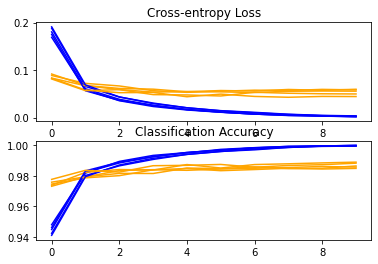

Accuracy: mean=98.682 std=0.154, n=5


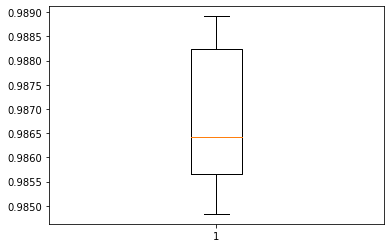

NameError: name 'model' is not defined

In [9]:
run_test_harness()